In [ ]:
import os
import numpy as np
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, Subset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# Задача 1

Проведите инстанс-сегментацию объектов на изображениях из датасета PennFudanPed [https://drive.google.com/drive/folders/1Rs9LY7PQtFVsK0mlr-BV5pvsNIofBDTo?usp=sharing](https://drive.google.com/drive/folders/1Rs9LY7PQtFVsK0mlr-BV5pvsNIofBDTo?usp=sharing)

In [ ]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'PNGImages')))
        self.masks = sorted(os.listdir(os.path.join(root, 'PedMasks')))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, 'PNGImages', self.imgs[idx])).convert('RGB')
        mask = np.array(Image.open(os.path.join(self.root, 'PedMasks', self.masks[idx])))
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]
        masks = np.stack([mask == oid for oid in obj_ids], axis=0)
        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            if (xmax - xmin) <= 10 or (ymax - ymin) <= 10:
                xmax = xmin + 10
                ymax = ymin + 10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'masks': masks,
                  'image_id': image_id, 'area': area, 'iscrowd': iscrowd}
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if img.dtype in (torch.float32, torch.uint8):
            img = img / 255.0
        return img, target

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

root = 'data/PennFudanPed'
full = PennFudanDataset(root)
n = len(full)
idxs = torch.randperm(n).tolist()
train_size = int(0.8 * n)
train_idxs, test_idxs = idxs[:train_size], idxs[train_size:]
dataset = Subset(PennFudanDataset(root, transforms=get_transform(train=True)), train_idxs)
dataset_test = Subset(PennFudanDataset(root, transforms=get_transform(train=False)), test_idxs)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
)

num_classes = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-5)

num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    res = evaluate(model, data_loader_test, device=device)

/home/danya/anaconda3/envs/new/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/danya/anaconda3/envs/new/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/danya/Рабочий стол/Финашка/Машинное зрение/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/68]  eta: 0:00:35  lr: 0.000002  loss: 5.1241 (5.1241)  loss_classifier: 0.5838 (0.5838)  loss_box_reg: 0.2860 (0.2860)  loss_mask: 4.2037 (4.2037)  loss_objectness: 0.0475 (0.0475)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.5210  data: 0.0110  max mem: 2204
Epoch: [0]  [67/68]  eta: 0:00:00  lr: 0.000100  loss: 0.3145 (1.1462)  loss_classifier: 0.0439 (0.1597)  loss_box_reg: 0.0956 (0.1849)  loss_mask: 0.1807 (0.7846)  loss_objectness: 0.0002 (0.0097)  loss_rpn_box_reg: 0.0053 (0.0073)  time: 0.1450  data: 0.0123  max mem: 2785
Epoch: [0] Total time: 0:00:10 (0.1492 s / it)
creating index...
index created!
Test:  [ 0/34]  eta: 0:00:01  model_time: 0.0410 (0.0410)  evaluator_time: 0.0059 (0.0059)  time: 0.0564  data: 0.0093  max mem: 2785
Test:  [33/34]  eta: 0:00:00  model_time: 0.0254 (0.0276)  evaluator_time: 0.0016 (0.0027)  time: 0.0335  data: 0.0054  max mem: 2785
Test: Total time: 0:00:01 (0.0362 s / it)
Averaged stats: model_time: 0.0254 (0.0276)  evaluator_tim

# Задача 2

На основе задачи 1:
1. Визуализируйте примеры из датасета так, чтоб были видны как
маски так и bounding box-ы.
2. Добавьте в __getitem__() подсчет количества объектов на изображении и включите эту информацию в target

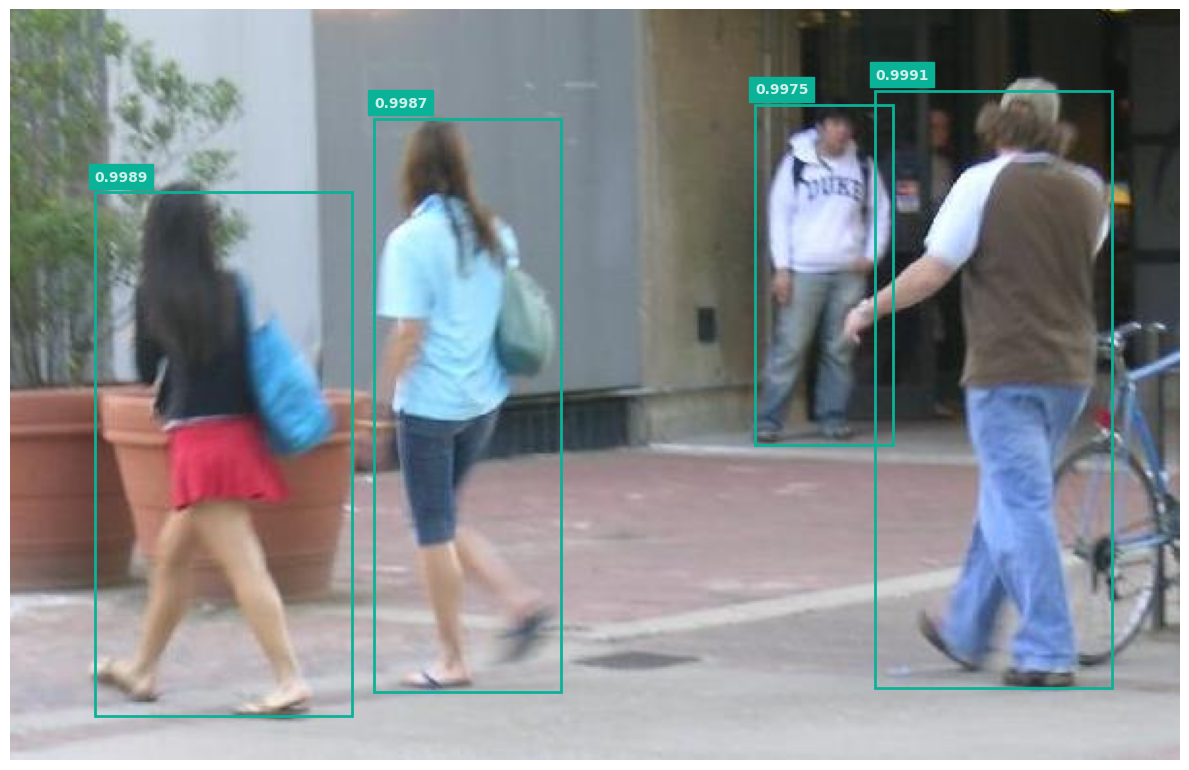

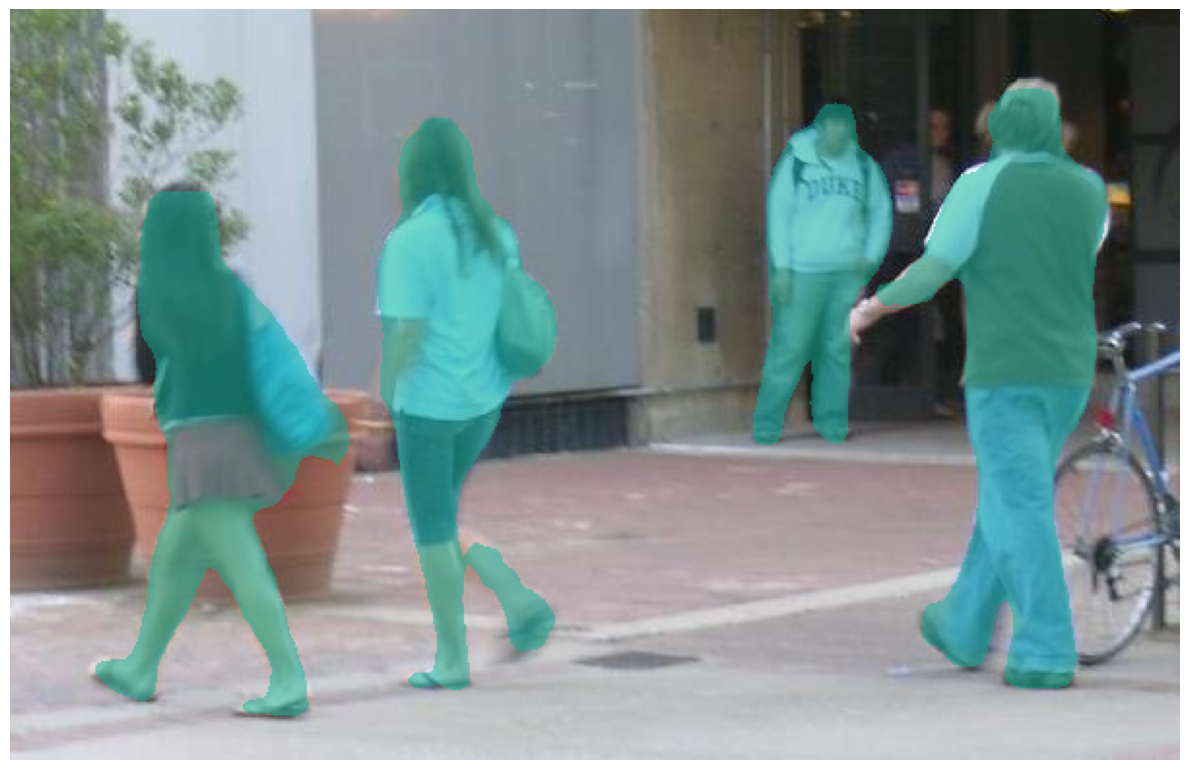

Класс person: 4 объектов, средняя уверенность 0.999


In [ ]:
model.eval()

im, _ = dataset_test[1]

orig = im.mul(255).byte().cpu().permute(1, 2, 0).numpy()

with torch.no_grad():
    pred = model([im.to(device)])[0]

boxes  = pred['boxes']
masks  = pred['masks']
labels = pred['labels']
scores = pred['scores']

threshold = 0.7
keep = scores > threshold
boxes  = boxes[keep]
masks  = masks[keep]
labels = labels[keep]
scores = scores[keep]

stats = defaultdict(lambda: {'count': 0, 'score_sum': 0.0})
for label, score in zip(labels, scores):
    lid = label.item()
    stats[lid]['count'] += 1
    stats[lid]['score_sum'] += score.item()

colors = {}
def get_color(label):
    lid = label.item()
    if lid not in colors:
        colors[lid] = np.random.rand(3,)
    return colors[lid]

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(orig)
for box, label, score in zip(boxes, labels, scores):
    color = get_color(label)
    x1, y1, x2, y2 = box.cpu().numpy()
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                     linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 6,
            f'{score:.4f}',
            fontsize=10, weight='bold',
            color='white', backgroundcolor=color, alpha=0.8)
ax.axis('off')
plt.tight_layout()
plt.show()

mask_overlay = orig.copy()
for mask, label in zip(masks, labels):
    color = (get_color(label) * 255).astype(np.uint8)
    m = mask[0].cpu().numpy() > 0.5
    mask_overlay[m] = mask_overlay[m] * 0.5 + color * 0.5

fig2, ax2 = plt.subplots(1, figsize=(12, 8))
ax2.imshow(mask_overlay.astype(np.uint8))
ax2.axis('off')
plt.tight_layout()
plt.show()

classes = {1: 'person'}
for lid, data in stats.items():
    count = data['count']
    avg_score = data['score_sum'] / count if count > 0 else 0.0
    print(f'Класс {classes.get(lid, lid)}: {count} объектов, средняя уверенность {avg_score:.3f}')

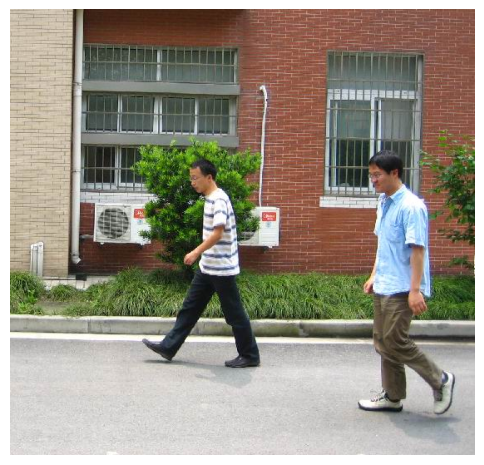

Index = 0, num_objects = 2


In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'PNGImages')))
        self.masks = sorted(os.listdir(os.path.join(root, 'PedMasks')))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, 'PNGImages', self.imgs[idx])).convert('RGB')
        mask = np.array(Image.open(os.path.join(self.root, 'PedMasks', self.masks[idx])))
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]
        num_objects = len(obj_ids)

        masks = np.stack([mask == oid for oid in obj_ids], axis=0)

        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            if (xmax - xmin) <= 10 or (ymax - ymin) <= 10:
                xmax = xmin + 10
                ymax = ymin + 10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((num_objects,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objects,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd,
            'num_objects': num_objects
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if isinstance(img, torch.Tensor) and img.dtype in (torch.float32, torch.uint8):
            img = img / 255.0
        return img, target

root = 'data/PennFudanPed'
dataset = PennFudanDataset(root)

idx = 0
img, target = dataset[idx]

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

print(f'Index = {idx}, num_objects = {target['num_objects']}')